# Densely Connected Convolutional Networks (DenseNets) on CIFAR10


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk

In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


#### Main takeways of the DenseNet paper (https://github.com/liuzhuang13/DenseNet)

_These are my notes, kindly ignore_

1. Concatenation of features (filters)

   - In contrast to ResNets, DenseNets never combine features through summation before they are passed into a layer ($L$ connections).
   - Instead, features are combined by concatenating them ($\frac{L(L+1)}{2}$ connections).

   This concatenation of feature maps from all previous is the dense connections referred to in DenseNets.

2. Dense Connections improve gradient flow (flow of information)

   - Each layer has direct access to the gradients from the loss function and the originial input signal leading to an implicit deep supervision.
   - Since each layer receives direct connections from all previous layers, the gradient signal has multiple paths to travel back to the early layers.
   - Prevents vanishing gradients.

3. Feature Reuse reduces parameters and has a regularizing effect.

   - Makes it easy to train.
   - feature reuse, reduces parameters -> reduces redundancy -> avoids memorization -> less overfitting
   - dense connections leads to an multiple feature representations leading to an ensemble effect -> improved generalization

4. Growth rate (k)

   - k controls how much new info each layer contributes. Say, k = 32, each layer adds 32 feature maps to the total

5. Dense Blocks & Transition Layers
   - Dense blocks - multiple layers connected densely
   - Transition layers - BatchNorm, 1x1 Conv (bottleneck), & Ave Pooling - reduces the feature map size

Training (for reference)

- Batch size: 64
- Epochs: 300
- Optimizer: SGD with momentum (0.9)
- Initial learning rate of 0.1, divided by 10 at 50% and 75% of total epochs
- Weight decay: 1e-4
- No dropout was used
- Data Augmentation: Mirroring (Random horizontal flip) + Shifting (Random shifts)


#### Load dataset


In [3]:
# Load data
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
)

In [4]:
print(len(train_images))
print(len(test_images))

50000
10000


#### Display a few images


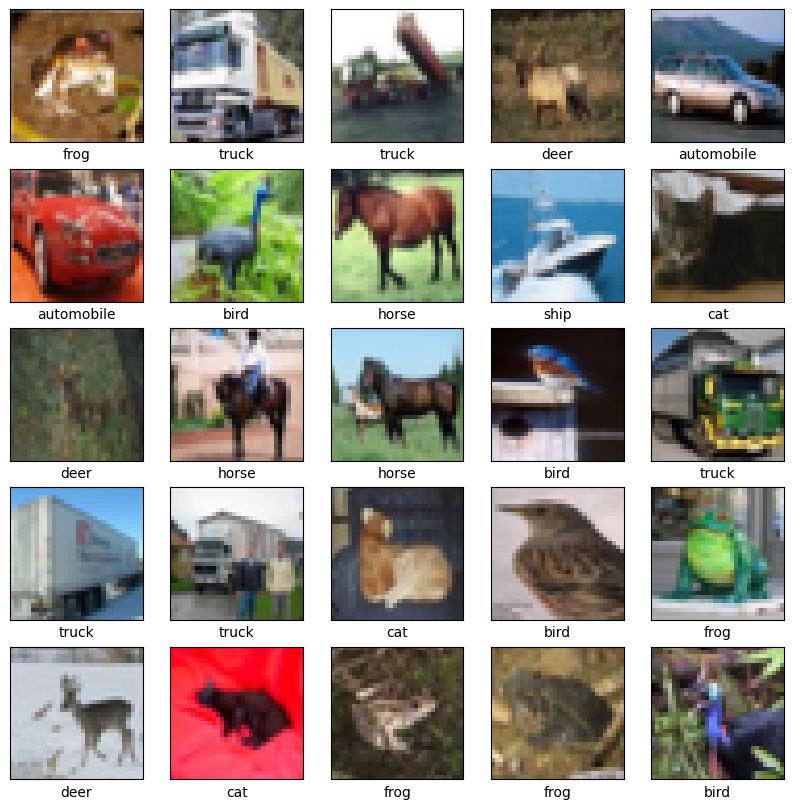

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [6]:
# Plot model performance
def plot_history(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    train_acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss)
    plt.plot(np.arange(1, len(train_loss) + 1), val_loss)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(122)
    plt.plot(np.arange(1, len(train_loss) + 1), train_acc)
    plt.plot(np.arange(1, len(train_loss) + 1), val_acc)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

### Custom DenseBlock and TransitionLayer


#### DenseBlock

([For each layer]:) BatchNormalization → ReLU → 1x1 Conv2D → BatchNormalization → ReLU → 3x3 Conv2D → Concatenate


In [7]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, growth_rate, bottleneck=False, dropout_rate=0.2):
        super(DenseBlock, self).__init__()

        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.bottleneck = bottleneck
        self.dropout_rate = dropout_rate

        self.layers_list = []
        for _ in range(num_layers):
            # Create a layer composition function
            layer_composition = []
            if bottleneck:
                layer_composition.append(
                    tf.keras.layers.Conv2D(
                        4 * growth_rate,
                        kernel_size=(1, 1),
                        padding="same",
                        kernel_initializer="he_uniform",
                    )
                )
                layer_composition.append(tf.keras.layers.BatchNormalization())
                layer_composition.append(tf.keras.layers.ReLU())
                layer_composition.append(tf.keras.layers.Dropout(self.dropout_rate))

            layer_composition.extend(
                [
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),
                    tf.keras.layers.Conv2D(
                        growth_rate,
                        kernel_size=(3, 3),
                        padding="same",
                        kernel_initializer="he_uniform",
                    ),
                    tf.keras.layers.Dropout(self.dropout_rate),
                ]
            )
            self.layers_list.append(layer_composition)

        self.concat_layer = tf.keras.layers.Concatenate()

    def call(self, x):
        inputs = [x]  # store the feature maps

        for i in range(self.num_layers):
            layer_composition = self.layers_list[i]  # get current layer composition

            y = x

            for layer in layer_composition:
                y = layer(y)

            # Add to inputs list
            inputs.append(y)

            # concat - feature reuse
            x = self.concat_layer(inputs)

        return x

#### TransitionLayer

BatchNormalization → ReLU → 1x1 Conv2D → AveragePooling2D


In [8]:
# Transition Layer
class TransitionLayer(tf.keras.layers.Layer):
    def __init__(self, compression_factor):
        super(TransitionLayer, self).__init__()

        self.compression_factor = compression_factor  # compression_factor factor

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        channels = int(self.compression_factor * input_shape[-1])
        self.conv = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1), padding="same")
        super(TransitionLayer, self).build(input_shape)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        out = self.avg_pool(x)
        return out

## Data augmentation (Pipeline-based) [experiments]


In [9]:
# train and validation sets split
train_images, val_images, train_labels, val_labels = (
    sk.model_selection.train_test_split(
        train_images, train_labels, test_size=0.1, random_state=42
    )
)


# data augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # mirroring
        tf.keras.layers.RandomTranslation(0.1, 0.1), # shifting
    ],
    name="data_augmentation",
)


# preprocess data augmentation
def preprocess_data_augmentation(x, y):
    x = data_augmentation(x, training=True)
    return x, y


BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# train set
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = (
    train_ds.shuffle(buffer_size=5000)
    .batch(BATCH_SIZE)
    .map(preprocess_data_augmentation, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

# validation set
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# test set
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Model Building


### Growth rate, k = 24, bottlenecks, data_aug(model-based), 2.7M parameters - 89.8%


In [ ]:
GROWTH_RATE = 24
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_202 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_10 (DenseBlock)          │ (None, 32, 32, 208)         │         201,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_7 (TransitionLayer) │ (None, 16, 16, 104)         │          22,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_11 (DenseBlock)          │ (None, 16, 16, 392)         │         531,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_8 (TransitionLayer) │ (None, 8, 8, 196)           │          78,596 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_12 (DenseBlock)          │ (None, 8, 8, 772)           │       1,606,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_9 (TransitionLayer) │ (None, 4, 4, 386)           │         301,466 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 386)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,747,284 (10.48 MB)

 Trainable params: 2,728,412 (10.41 MB)

 Non-trainable params: 18,872 (73.72 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 235s 267ms/step - acc: 0.3523 - loss: 1.8158 - val_acc: 0.4944 - val_loss: 1.4381
Epoch 2/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.6015 - loss: 1.1163 - val_acc: 0.5973 - val_loss: 1.2380
Epoch 3/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.6905 - loss: 0.8636 - val_acc: 0.6296 - val_loss: 1.1793
Epoch 4/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.7537 - loss: 0.7041 - val_acc: 0.5947 - val_loss: 1.3425
Epoch 5/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.7891 - loss: 0.6088 - val_acc: 0.6531 - val_loss: 1.1060
Epoch 6/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.8156 - loss: 0.5366 - val_acc: 0.7747 - val_loss: 0.6952
Epoch 7/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.8357 - loss: 0.4795 - val_acc: 0.7622 - val_loss: 0.7372
Epoch 8/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.8483 - loss: 0.4418 - val_acc: 0.7998 - val_loss: 0.5803
Epoch 9/100
633/


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - acc: 0.8979 - loss: 0.3903


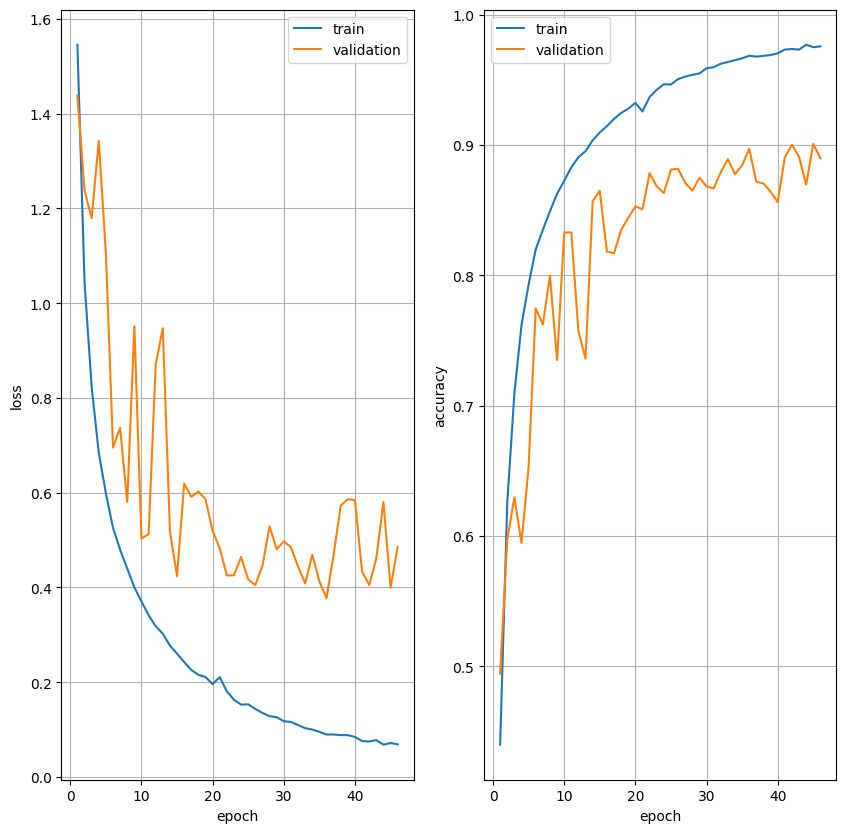

In [ ]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_images, test_labels)

### Growth rate, k = 12, bottleneck, dropout, data_aug(pipeline-based), 0.9M parameters - 89.54%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_7 (DenseBlock)           │ (None, 32, 32, 84)          │          45,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 84)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_7 (TransitionLayer) │ (None, 16, 16, 42)          │           3,906 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_8 (DenseBlock)           │ (None, 16, 16, 186)         │         129,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_8 (TransitionLayer) │ (None, 8, 8, 93)            │          18,135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_9 (DenseBlock)           │ (None, 8, 8, 381)           │         401,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 381)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_9 (TransitionLayer) │ (None, 4, 4, 190)           │          74,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_10 (DenseBlock)          │ (None, 4, 4, 334)           │         214,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 4, 334)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_10                  │ (None, 2, 2, 167)           │          57,281 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 167)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,226 (3.61 MB)

 Trainable params: 934,888 (3.57 MB)

 Non-trainable params: 12,338 (48.20 KB)

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 261s 187ms/step - acc: 0.3629 - loss: 1.7207 - val_acc: 0.5012 - val_loss: 1.4524
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - acc: 0.6131 - loss: 1.0841 - val_acc: 0.6026 - val_loss: 1.1830
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - acc: 0.7107 - loss: 0.8253 - val_acc: 0.6536 - val_loss: 1.1236
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - acc: 0.7587 - loss: 0.6942 - val_acc: 0.6900 - val_loss: 0.9271
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - acc: 0.7891 - loss: 0.6117 - val_acc: 0.7416 - val_loss: 0.8197
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - acc: 0.8088 - loss: 0.5565 - val_acc: 0.7508 - val_loss: 0.7792
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - acc: 0.8263 - loss: 0.5057 - val_acc: 0.7576 - val_loss: 0.7912
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - acc: 0.8394 - loss: 0.4655 - val_acc: 0.7410 - val_loss: 0.8198
Epoch 9/100
704/704 ━━━━━━━━━━

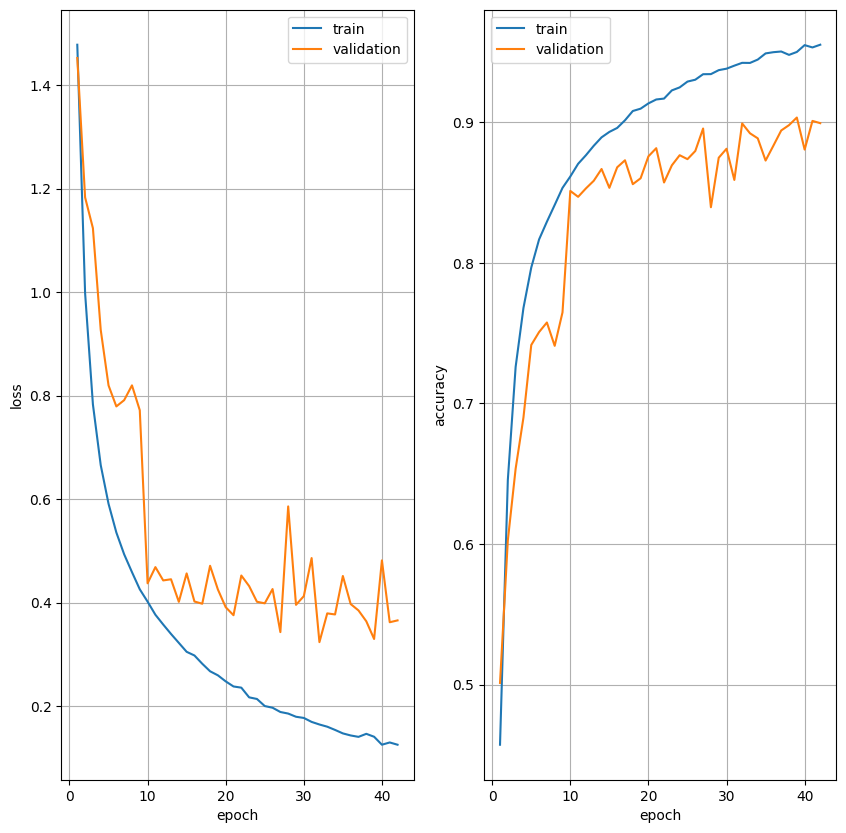

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - acc: 0.8954 - loss: 0.3467


### Growth rate, k = 12, bottleneck, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 0.9M parameters - 89.27%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2
EPOCHS = 100

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_11 (DenseBlock)          │ (None, 32, 32, 84)          │          45,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 84)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_11                  │ (None, 16, 16, 42)          │           3,906 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_12 (DenseBlock)          │ (None, 16, 16, 186)         │         129,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_12                  │ (None, 8, 8, 93)            │          18,135 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_13 (DenseBlock)          │ (None, 8, 8, 381)           │         401,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 8, 381)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_13                  │ (None, 4, 4, 190)           │          74,104 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_14 (DenseBlock)          │ (None, 4, 4, 334)           │         214,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 334)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_14                  │ (None, 2, 2, 167)           │          57,281 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 167)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,226 (3.61 MB)

 Trainable params: 934,888 (3.57 MB)

 Non-trainable params: 12,338 (48.20 KB)

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 182s 146ms/step - acc: 0.3034 - loss: 1.9018 - val_acc: 0.3678 - val_loss: 2.0353
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 109s 71ms/step - acc: 0.5104 - loss: 1.3579 - val_acc: 0.3880 - val_loss: 2.0008
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - acc: 0.6166 - loss: 1.0821 - val_acc: 0.5118 - val_loss: 1.6395
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - acc: 0.6937 - loss: 0.8803 - val_acc: 0.6718 - val_loss: 1.0152
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - acc: 0.7421 - loss: 0.7383 - val_acc: 0.7440 - val_loss: 0.7735
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - acc: 0.7722 - loss: 0.6592 - val_acc: 0.7602 - val_loss: 0.7157
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - acc: 0.7970 - loss: 0.5974 - val_acc: 0.7996 - val_loss: 0.5809
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - acc: 0.8108 - loss: 0.5567 - val_acc: 0.7546 - val_loss: 0.7793
Epoch 9/100
704/704 ━━━━━━━━━

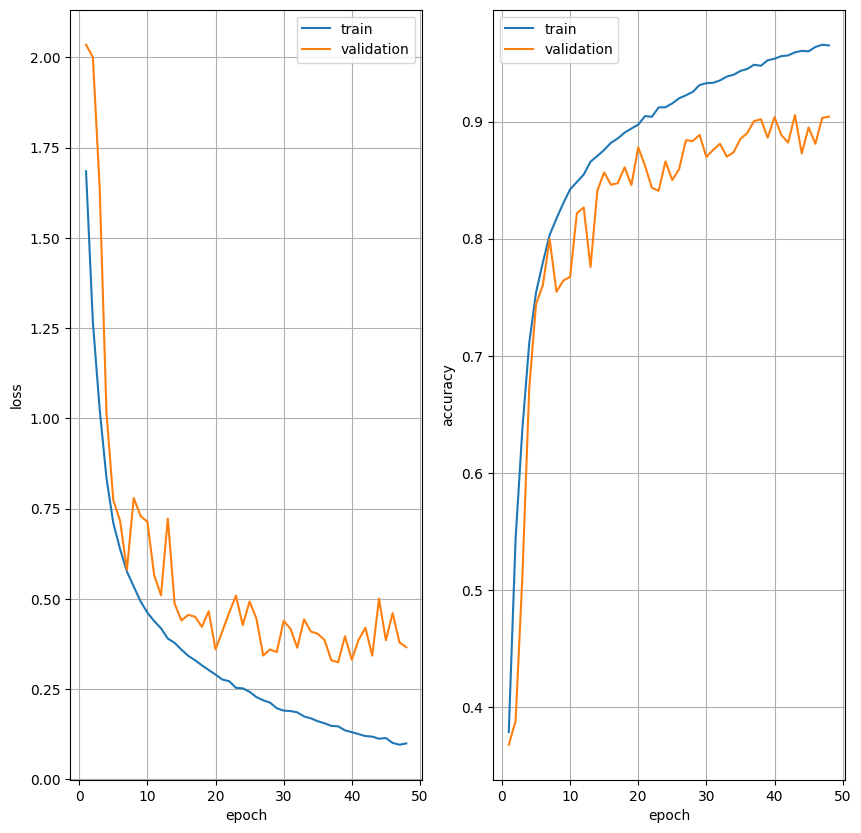

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - acc: 0.8927 - loss: 0.3791


### Growth rate, k = 36, bottleneck, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 8.2M parameters - 89.57%

In [ ]:
GROWTH_RATE = 36
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2
EPOCHS = 100

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_348 (Conv2D)                  │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_19 (DenseBlock)          │ (None, 32, 32, 228)         │         376,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32, 32, 228)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_19                  │ (None, 16, 16, 114)         │          27,018 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_20 (DenseBlock)          │ (None, 16, 16, 546)         │       1,114,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 546)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_20                  │ (None, 8, 8, 273)           │         151,515 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_21 (DenseBlock)          │ (None, 8, 8, 1137)          │       3,525,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 1137)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_21                  │ (None, 4, 4, 568)           │         650,932 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_22 (DenseBlock)          │ (None, 4, 4, 1000)          │       1,899,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4, 4, 1000)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_22                  │ (None, 2, 2, 500)           │         504,500 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,255,847 (31.49 MB)

 Trainable params: 8,218,921 (31.35 MB)

 Non-trainable params: 36,926 (144.24 KB)

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 356s 318ms/step - acc: 0.3397 - loss: 1.9187 - val_acc: 0.4718 - val_loss: 1.7260
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 183s 214ms/step - acc: 0.5877 - loss: 1.1569 - val_acc: 0.4850 - val_loss: 1.6862
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 203s 215ms/step - acc: 0.7039 - loss: 0.8483 - val_acc: 0.6042 - val_loss: 1.3195
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.7611 - loss: 0.6892 - val_acc: 0.6304 - val_loss: 1.4232
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 201s 215ms/step - acc: 0.7986 - loss: 0.5895 - val_acc: 0.7694 - val_loss: 0.6889
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.8262 - loss: 0.5141 - val_acc: 0.7706 - val_loss: 0.7268
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.8389 - loss: 0.4800 - val_acc: 0.7680 - val_loss: 0.7305
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 215ms/step - acc: 0.8499 - loss: 0.4429 - val_acc: 0.8108 - val_loss: 0.6088
Epoch 9/100
704/


157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - acc: 0.8957 - loss: 0.4001


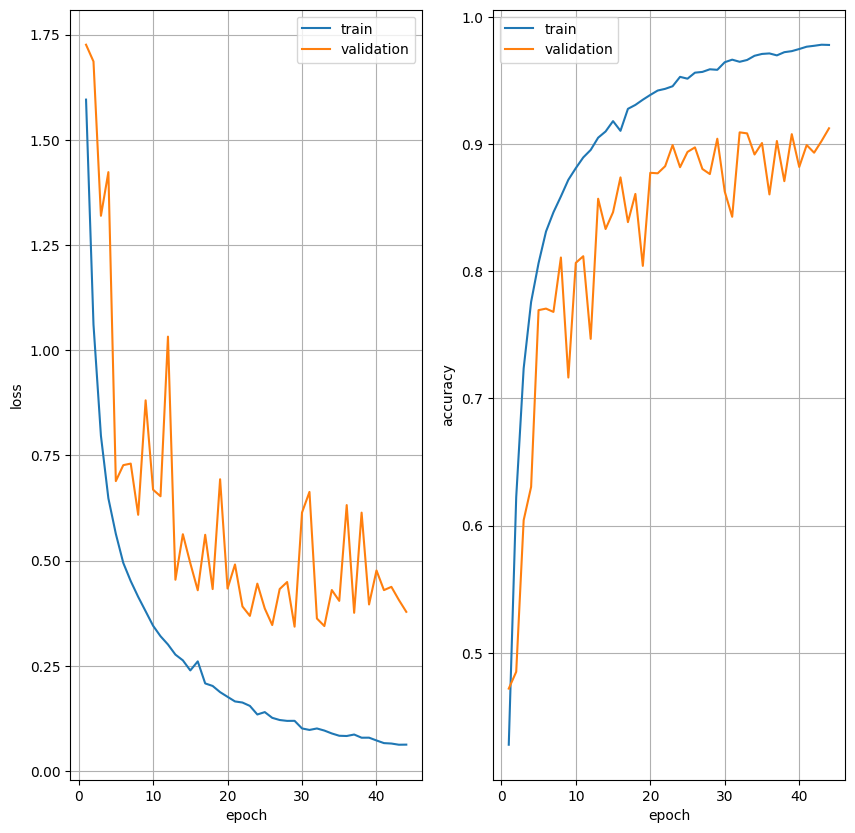

In [ ]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_ds)